# Resource Utilization of Pandas and Spark DataFtame 

### Import the required libraries

In [1]:
import pandas as pd
from pyspark.sql import SparkSession
import psutil
import time

### Create a Spark session to work with Spark DataFrames

In [2]:
spark = SparkSession.builder \
    .appName("Resource Utilization") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/06 07:39:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Loading the Enron email dataset

In [3]:
# Load the dataset using Pandas
pandas_df = pd.read_csv("emails.csv")

# Load the dataset using Spark
spark_df = spark.read.csv("emails.csv", header=True, inferSchema=True)


### Create a function that will utilize the psutil library to measure the CPU, memory, and disk usage before and after executing a given operation.

In [4]:
def measure_resource_utilization(operation, dataframe):
    # Get initial resource usage
    cpu_percent_initial = psutil.cpu_percent()
    memory_initial = psutil.virtual_memory().used
    disk_initial = psutil.disk_usage('/').used

    print("Initial resource usage captured.")

    # Perform the operation
    try:
        start_time = time.time()
        operation(dataframe)
        end_time = time.time()
        print("Operation completed.")
    except Exception as e:
        print("Error during operation:", e)
        return None, None, None, None

    # Get final resource usage
    cpu_percent_final = psutil.cpu_percent()
    memory_final = psutil.virtual_memory().used
    disk_final = psutil.disk_usage('/').used

    print("Final resource usage captured.")

    # Calculate resource usage and time taken
    cpu_percent_diff = cpu_percent_final - cpu_percent_initial
    memory_diff = memory_final - memory_initial
    disk_diff = disk_final - disk_initial
    time_taken = end_time - start_time

    return cpu_percent_diff, memory_diff, disk_diff, time_taken


### Check the column names in the dataset

In [5]:
# Print Pandas DataFrame columns
print("Pandas DataFrame columns:", pandas_df.columns)

# Print Spark DataFrame columns
print("Spark DataFrame columns:", spark_df.columns)

Pandas DataFrame columns: Index(['file', 'message'], dtype='object')
Spark DataFrame columns: ['file', 'message']


### Define operations we want to execute 

In [6]:
def operation_pandas(dataframe):
    result = dataframe.groupby("message").size().sort_values(ascending=False)

def operation_spark(dataframe):
    result = dataframe.groupBy("message").count().orderBy("count", ascending=False)


### Measure resource utilization

In [7]:
# Measure resource utilization for Pandas
cpu_pd, mem_pd, disk_pd, time_pd = measure_resource_utilization(operation_pandas, pandas_df)

# Measure resource utilization for Spark
cpu_sp, mem_sp, disk_sp, time_sp = measure_resource_utilization(operation_spark, spark_df)


Initial resource usage captured.
Operation completed.
Final resource usage captured.
Initial resource usage captured.
Operation completed.
Final resource usage captured.


### Resource utilization and performance of Pandas and Spark DataFrames based on the calculated metrics

In [8]:
print("Pandas - CPU: {:.2f}%, Memory: {:.2f} MB, Disk: {:.2f} MB, Time: {:.2f} s".format(
    cpu_pd, mem_pd / (1024**2), disk_pd / (1024**2), time_pd))

print("Spark - CPU: {:.2f}%, Memory: {:.2f} MB, Disk: {:.2f} MB, Time: {:.2f} s".format(
    cpu_sp, mem_sp / (1024**2), disk_sp / (1024**2), time_sp))

Pandas - CPU: -9.60%, Memory: 39.92 MB, Disk: 1.09 MB, Time: 3.74 s
Spark - CPU: 39.40%, Memory: 0.54 MB, Disk: 0.00 MB, Time: 0.09 s


### Graph for visualizing the result comparison

In [9]:
import matplotlib.pyplot as plt
import numpy as np

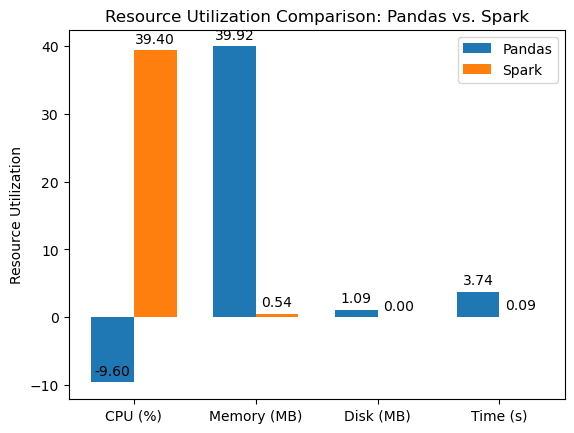

In [12]:
# Set up data for the bar graph
labels = ['CPU (%)', 'Memory (MB)', 'Disk (MB)', 'Time (s)']
pandas_data = [cpu_pd, mem_pd / (1024**2), disk_pd / (1024**2), time_pd]
spark_data = [cpu_sp, mem_sp / (1024**2), disk_sp / (1024**2), time_sp]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Create the bar graph
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pandas_data, width, label='Pandas')
rects2 = ax.bar(x + width/2, spark_data, width, label='Spark')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Resource Utilization')
ax.set_title('Resource Utilization Comparison: Pandas vs. Spark')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to label the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Show the bar graph
plt.show()